In [5]:
from google.colab import drive, sheets
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, concatenate, TimeDistributed, Reshape, Dropout, Bidirectional, BatchNormalization, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences, TimeseriesGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import os

In [ ]:
drive.mount('/content/drive', force_remount=True)
file_path = '/content/drive/MyDrive/ML/final_project/data/processed/df_merged_vix.csv'
data = pd.read_csv(file_path)

# Convert 'date' column to datetime and sort by ticker and date (chronological order)
data['date'] = pd.to_datetime(data['date'])
data.sort_values(['ticker', 'date'], inplace=True)
data.reset_index(drop=True, inplace=True)

# Get unique tickers (e.g., NVDA, PG, VOO)
tickers = data['ticker'].unique()

# Dictionaries to store processing objects and data splits per ticker
tokenizers = {}
max_seq_len = {}
scalers = {}
train_sequences = {}
test_sequences = {}

# Define window size and numeric feature names
window_size = 3  # using 3 days as the sequence length
numeric_features = ['close', 'volume', 'open', 'high', 'low','vix_val']

test_dfs = {}
for ticker in tickers:
    # Filter data for the current ticker
    df_ticker = data[data['ticker'] == ticker].reset_index(drop=True)

    # 80/20 chronological split (first 80% for training, later 20% for testing)
    split_index = int(len(df_ticker) * 0.8)
    train_df = df_ticker.iloc[:split_index].reset_index(drop=True)
    test_df = df_ticker.iloc[split_index:].reset_index(drop=True)

    test_dfs[ticker] = test_df

    # Ensure headlines (title) are strings and fill any missing values
    train_df['title'] = train_df['title'].fillna('').astype(str)
    test_df['title'] = test_df['title'].fillna('').astype(str)

    # Tokenize headlines using Keras Tokenizer (fit on training data only)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_df['title'])
    tokenizers[ticker] = tokenizer

    # Convert titles to sequences and then pad them
    train_title_seq = tokenizer.texts_to_sequences(train_df['title'])
    test_title_seq = tokenizer.texts_to_sequences(test_df['title'])

    # Determine the maximum sequence length for this ticker
    max_len = max(max(len(seq) for seq in train_title_seq), max(len(seq) for seq in test_title_seq))
    max_seq_len[ticker] = max_len

    X_train_title_pad = pad_sequences(train_title_seq, maxlen=max_len, padding='post')
    X_test_title_pad = pad_sequences(test_title_seq, maxlen=max_len, padding='post')

    # Scale numeric features with MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(train_df[numeric_features])
    scalers[ticker] = scaler

    train_num_scaled = scaler.transform(train_df[numeric_features])
    test_num_scaled = scaler.transform(test_df[numeric_features])

    # Build sliding-window sequences for the training data
    X_num_train, X_text_train, y_train = [], [], []
    for i in range(len(train_num_scaled) - window_size):
        X_num_train.append(train_num_scaled[i : i + window_size])
        X_text_train.append(X_train_title_pad[i : i + window_size])
        # The target is the next day’s 'close' price (first feature)
        y_train.append(train_num_scaled[i + window_size][0])
    X_num_train = np.array(X_num_train)
    X_text_train = np.array(X_text_train)
    y_train = np.array(y_train)

    # Build sliding-window sequences for the testing data
    X_num_test, X_text_test, y_test = [], [], []
    for i in range(len(test_num_scaled) - window_size):
        X_num_test.append(test_num_scaled[i : i + window_size])
        X_text_test.append(X_test_title_pad[i : i + window_size])
        y_test.append(test_num_scaled[i + window_size][0])
    X_num_test = np.array(X_num_test)
    X_text_test = np.array(X_text_test)
    y_test = np.array(y_test)

    train_sequences[ticker] = (X_num_train, X_text_train, y_train)
    test_sequences[ticker] = (X_num_test, X_text_test, y_test)

Mounted at /content/drive


In [ ]:
def build_model(ticker, model_loss='mse', lr=1e-3):
    # parameters from your preprocessing
    seq_length    = max_seq_len[ticker]
    vocab_size    = len(tokenizers[ticker].word_index) + 1
    n_num_features= len(numeric_features)
    emb_dim       = 100   # increase embedding size
    win           = window_size

    num_in = Input(shape=(win, n_num_features), name=f"{ticker}_num_input")
    x = Bidirectional(
            LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
        )(num_in)
    x = LSTM(32, dropout=0.2, recurrent_dropout=0.2)(x)


    txt_in = Input(shape=(win, seq_length), name=f"{ticker}_txt_input")
    e = TimeDistributed(
            Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=seq_length)
        )(txt_in)
    e = TimeDistributed(
            Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
        )(e)
    y = LSTM(32, dropout=0.2, recurrent_dropout=0.2)(e)


    merged = concatenate([x, y])
    z = Dense(64)(merged)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)
    z = Dropout(0.3)(z)
    z = Dense(32, activation='relu')(z)
    output = Dense(1, activation='linear')(z)

    model = Model(inputs=[num_in, txt_in], outputs=output)
    model.compile(
        loss=model_loss,
        optimizer=Adam(learning_rate=lr),
        metrics=['mae']
    )
    return model

# Build a dictionary of models (one per ticker)
models = {}
for ticker in tickers:
    models[ticker] = build_model(ticker,model_loss='mse')
    print(f"\n{ticker} model summary:")
    models[ticker].summary()


NVDA model summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ NVDA_txt_input      │ (None, 3, 480)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NVDA_num_input      │ (None, 3, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 3, 480,    │    754,800 │ NVDA_txt_input[0… │
│ (TimeDistributed)   │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 3, 128)    │     36,352 │ NVDA_num_input[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 3, 64)     │     34,048 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     20,608 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 32)        │     12,416 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 864,753 (3.30 MB)

 Trainable params: 864,625 (3.30 MB)

 Non-trainable params: 128 (512.00 B)


PG model summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ PG_txt_input        │ (None, 3, 46)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PG_num_input        │ (None, 3, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 3, 46,     │    174,600 │ PG_txt_input[0][… │
│ (TimeDistributed)   │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 3, 128)    │     36,352 │ PG_num_input[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 3, 64)     │     34,048 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 32)        │     20,608 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 32)        │     12,416 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64)        │          0 │ lstm_5[0][0],     │
│ (Concatenate)       │                   │            │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      4,160 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         33 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 284,553 (1.09 MB)

 Trainable params: 284,425 (1.08 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# Mount the drive and define the model saving directory
drive.mount('/content/drive', force_remount=True)
save_dir = "/content/drive/MyDrive/ML/final_project/results/models_v4"
os.makedirs(save_dir, exist_ok=True)

# Define the path for the loss history JSON file
history_filepath = os.path.join(save_dir, "loss_histories.json")

# If the JSON file exists, load its content; otherwise, start with an empty dictionary
if os.path.exists(history_filepath):
    with open(history_filepath, "r") as f:
        loss_histories = json.load(f)
    print(f"Loaded existing loss histories from {history_filepath}")
else:
    loss_histories = {}

# Loop over the tickers and train or load models accordingly.
for ticker in tickers:
    model_filepath = os.path.join(save_dir, f"{ticker}_model.keras")

    # Check if model file already exists
    if os.path.exists(model_filepath):
        print(f"\nModel for {ticker} already exists at {model_filepath}. Loading model and skipping training.")
        models[ticker] = load_model(model_filepath)
        # Even if we skip training, ensure that the ticker is present in loss_histories (or leave it as is)
        if ticker not in loss_histories:
            loss_histories[ticker] = {}  # You might want to leave it empty or indicate "not trained"
        continue  # Skip training for this ticker

    print(f"\n--- Training model for {ticker} ---")
    X_num_train, X_text_train, y_train = train_sequences[ticker]
    X_num_test, X_text_test, y_test = test_sequences[ticker]
    model = models[ticker]

    # Train the model
    history = model.fit(
        [X_num_train, X_text_train], y_train,
        validation_data=([X_num_test, X_text_test], y_test),
        epochs=50,
        batch_size=32,
        verbose=1
    )

    # Update the loss_histories dictionary for this ticker with the new history
    loss_histories[ticker] = history.history

    # Save the model in native Keras format
    model.save(model_filepath)
    print(f"Saved model for {ticker} to {model_filepath}")

# After processing all tickers, write the updated loss_histories back to the JSON file
with open(history_filepath, "w") as f:
    json.dump(loss_histories, f)

Mounted at /content/drive

--- Training model for NVDA ---
Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 336s 3s/step - loss: 0.0600 - mae: 0.1752 - val_loss: 7.4630 - val_mae: 2.4630
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - loss: 0.0114 - mae: 0.0788 - val_loss: 7.1462 - val_mae: 2.4035
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - loss: 0.0095 - mae: 0.0702 - val_loss: 6.9287 - val_mae: 2.3610
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - loss: 0.0060 - mae: 0.0569 - val_loss: 6.4694 - val_mae: 2.2774
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 332s 3s/step - loss: 0.0059 - mae: 0.0539 - val_loss: 5.5875 - val_mae: 2.1014
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - loss: 0.0043 - mae: 0.0480 - val_loss: 4.8677 - val_mae: 1.9462
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - loss: 0.0044 - mae: 0.0475 - val_loss: 4.2697 - val_mae: 1.8255
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 306s 3s/step - loss: 0.0038 - mae: 0.0441 - val_loss: 3.1958 - val_mae: 1.5565
Epoch

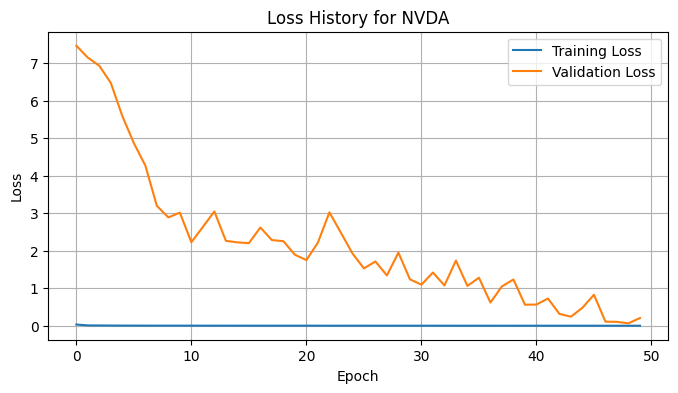

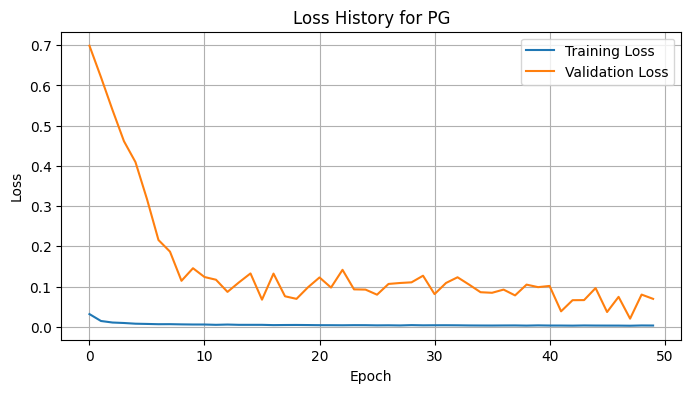

In [ ]:
history_filepath = "/content/drive/MyDrive/ML/final_project/results/models_v4/loss_histories.json"
with open(history_filepath, "r") as f:
    loss_histories = json.load(f)

# Assume that tickers is a list like: ["NVDA", "PG", "VOO"]
for ticker in tickers:
    ticker_history = loss_histories.get(ticker, None)
    if ticker_history is None:
        print(f"No history found for {ticker}")
        continue

    plt.figure(figsize=(8, 4))
    plt.plot(ticker_history["loss"], label="Training Loss")
    plt.plot(ticker_history["val_loss"], label="Validation Loss")
    plt.title(f"Loss History for {ticker}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
for ticker in tickers:
    print(f"\n--- Evaluating model for {ticker} ---")
    # Optionally, load the model from disk if needed:
    # model = load_model(os.path.join(save_dir, f"{ticker}_model.keras"))
    model = models[ticker]  # Using the model in-memory

    X_num_test, X_text_test, y_test = test_sequences[ticker]

    # Predict on the test data
    y_pred_scaled = model.predict([X_num_test, X_text_test]).flatten()

    # Invert scaling for predictions and actual values using the scaler for this ticker
    scaler = scalers[ticker]
    close_idx = 0  # 'close' price is the first feature in numeric data
    close_min = scaler.data_min_[close_idx]
    close_max = scaler.data_max_[close_idx]

    y_pred = y_pred_scaled * (close_max - close_min) + close_min
    y_true = y_test * (close_max - close_min) + close_min

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    print(f"{ticker} - Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")


--- Evaluating model for NVDA ---
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 931ms/step
NVDA - Test RMSE: 94.1756, MAE: 85.4145

--- Evaluating model for PG ---
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step
PG - Test RMSE: 91.2934, MAE: 90.8439


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 441ms/step


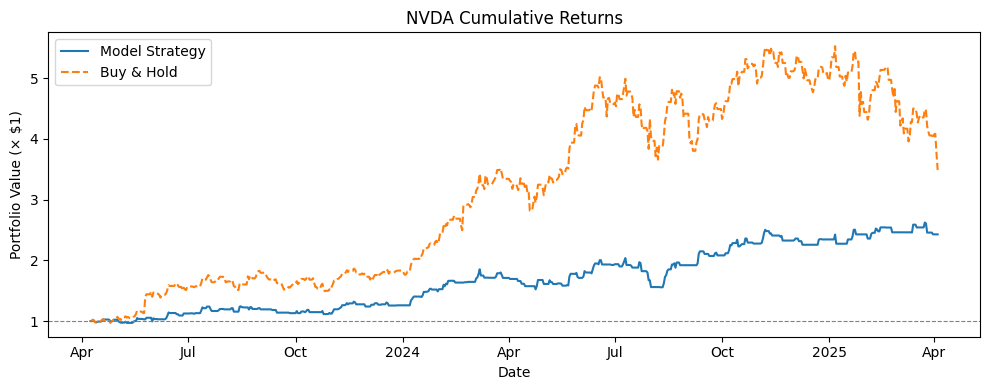

model:2.427815933297958
hold:3.488182860524476
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


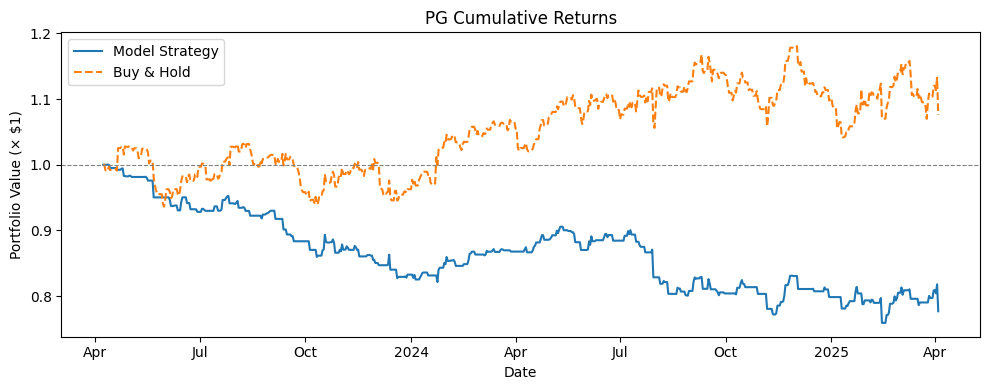

model:0.7768695688768179
hold:1.0757456313230838


In [ ]:
for ticker in tickers:
    # 1) Get test data
    Xn_t, Xt_t, yt_scaled = test_sequences[ticker]
    dates = pd.to_datetime(test_dfs[ticker]["date"]).iloc[window_size:].reset_index(drop=True)

    # 2) Predict and inverse‑scale via dummy trick
    y_pred_scaled = models[ticker].predict([Xn_t, Xt_t]).flatten()
    dummy = np.zeros((len(y_pred_scaled), len(numeric_features)))
    dummy[:, 0] = y_pred_scaled
    y_pred = scalers[ticker].inverse_transform(dummy)[:, 0]

    dummy_true = np.zeros((len(yt_scaled), len(numeric_features)))
    dummy_true[:, 0] = yt_scaled
    y_true = scalers[ticker].inverse_transform(dummy_true)[:, 0]

    # 3) Build daily returns for both strategies
    #  – Model strategy: long when pred↑, else flat
    signal = np.zeros_like(y_pred, dtype=int)
    signal[1:] = (y_pred[1:] > y_pred[:-1]).astype(int)
    pct_model = np.zeros_like(y_true)
    pct_model[1:] = np.where(signal[1:]==1, (y_true[1:]/y_true[:-1]) - 1, 0.0)
    cum_model = np.cumprod(1 + pct_model)

    #  – Buy & Hold: always long
    pct_hold = np.zeros_like(y_true)
    pct_hold[1:] = (y_true[1:]/y_true[:-1]) - 1
    cum_hold = np.cumprod(1 + pct_hold)

    # 4) Plot both on same axes
    plt.figure(figsize=(10, 4))
    plt.plot(dates, cum_model, label="Model Strategy")
    plt.plot(dates, cum_hold,  linestyle="--", label="Buy & Hold")
    plt.axhline(1.0, color="gray", lw=0.8, ls="--")
    plt.title(f"{ticker} Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value (× $1)")
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
    plt.tight_layout()
    plt.show()

    print(f'model:{cum_model[-1]}')
    print(f'hold:{cum_hold[-1]}')

In [2]:
pip freeze > requirements.txt

In [3]:
!head -n 50 requirements.txt

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.14.0.37.22
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.0
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1


In [6]:
print("CWD:", os.getcwd())
!ls -l

CWD: /content
total 20
-rw-r--r-- 1 root root 12469 Apr 22 18:52 requirements.txt
drwxr-xr-x 1 root root  4096 Apr 21 18:42 sample_data
